# Part 3 - Modelling

## Importing of Libraries


In [19]:
# importing sql libraries
import sqlite3

#importing libraries required for data analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#importing libraries for model
import joblib
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, roc_auc_score, recall_score, precision_score, f1_score, precision_recall_curve,average_precision_score, PrecisionRecallDisplay, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

## Importing from SQLite db


In [20]:
#Connecting to nhgh database 
sqliteConnection = sqlite3.connect('../data/nhgh.db')

#Querying from nhgh database. SELECT only the columns for the model building
data_model= pd.read_sql(
    '''
    SELECT age, dx, leg, waist, sub, gh, albumin, bun
    FROM nhgh
    ''', 
    sqliteConnection
)

## Model Dataset Preprocessing

### Set X and y Variables/Train Test Split

In [21]:
data_model

,age,dx,leg,waist,sub,gh,albumin,bun
0,34.166667,0,41.5,100.4,24.9,5.2,4.8,6.0
1,16.833333,0,42.0,74.7,10.5,5.7,4.6,9.0
2,60.166667,1,35.3,118.2,35.6,6.0,3.9,10.0
3,26.083333,0,41.7,103.7,23.2,5.1,4.2,8.0
4,49.666667,0,37.5,107.8,28.0,5.3,4.3,13.0
...,...,...,...,...,...,...,...,...
6790,33.000000,0,34.4,112.3,NaN,5.4,4.1,10.0
6791,48.916667,1,33.9,99.4,25.4,5.5,4.1,7.0
6792,27.500000,0,35.3,73.2,6.8,5.6,4.5,11.0
6793,75.750000,0,38.6,104.0,21.1,5.4,4.0,19.0


In [22]:
# Set X and y variables

X=data_model.drop('dx',axis=1)
y=data_model['dx']

#Train test split
X_train, X_test, y_train,y_test =train_test_split(
    X,
    y,
    stratify=y,
    test_size = 0.2,
    random_state=42,
)

In [23]:
#checking for the shape and class distribution
print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))


(5436,)
(1359,)
(5436, 7)
(1359, 7)
dx
0    4705
1     731
Name: count, dtype: int64
dx
0    0.865526
1    0.134474
Name: proportion, dtype: float64
dx
0    1176
1     183
Name: count, dtype: int64
dx
0    0.865342
1    0.134658
Name: proportion, dtype: float64


The shape of both post-split train and test sets were verified to ensure the they are aligned. Based on value count result, we found that proportion of negative classes is around 87% and the positive classes is around 13%, which is characteristic of imbalanced classes in this dataset as described in the previous section.

### Filling of null for Train and Test datasets



In order to prevent data leakage, we have to re-fit and re-transform KNNImputer on both the Train dataset before re-transforming the Test dataset. We cannot use the previous filled up values as there might be interactions across train to the test dataset. 

In [24]:
X_train.isnull().sum() #checking null value count before values are imputed

age          0
leg        184
waist      186
sub        772
gh           0
albumin     64
bun         64
dtype: int64

In [25]:
X_test.isnull().sum() #checking null value count before values are imputed

age          0
leg         47
waist       53
sub        199
gh           0
albumin     25
bun         25
dtype: int64

In [26]:
imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(imputer.fit_transform(X_train),columns = X_train.columns)

In [27]:
X_test = pd.DataFrame(imputer.transform(X_test),columns = X_test.columns)

In [28]:
X_train.isnull().sum() #checking after to see if values are imputed

age        0
leg        0
waist      0
sub        0
gh         0
albumin    0
bun        0
dtype: int64

In [29]:
X_test.isnull().sum() #checking after to see if values are imputed

age        0
leg        0
waist      0
sub        0
gh         0
albumin    0
bun        0
dtype: int64

### Standardization


In [30]:
ss=StandardScaler()
X_train_sc=ss.fit_transform(X_train)
X_test_sc=ss.transform(X_test)

Data standardization is the process of rescaling the attributes so that they have mean as 0 and variance as 1. The ultimate goal to perform standardization is to bring down all the features to a common scale without distorting the differences in the range of the values. This helps in terms of reducing computation time as the model will converge faster, as well as improving the accuracy of the model as the variance of all features are on the same scale. (source: https://medium.com/analytics-vidhya/what-is-the-use-of-data-standardization-and-where-do-we-use-it-in-machine-learning-97b71a294e24)

## Modelling

### Base Model

I will first perform a Logistic Regression with default parameters to obtain a Base Model to compare our subsequent models' metrics to. Sensitivity, Accuracy, Specificity, Precision, F1 Score, Train Score, Test Score and ROC AUC will be measured for each model to compare performance.

In [31]:
# Instantiate model.
logreg = LogisticRegression(max_iter = 5_000, random_state = 42)

# Fit model.
logreg.fit(X_train_sc, y_train)

# Generate predicted values.
preds = logreg.predict(X_test_sc)

#Generate predicted probabilities.
preds_proba = np.round(logreg.predict_proba(X_test_sc), 3)

In [32]:
xval = cross_val_score(
    logreg,
    X_train_sc,
    y_train,
    cv = 5,
    scoring = 'roc_auc',
).mean()

In [33]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 5000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [34]:
#metrics calculations
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
acc = (tp + tn) / (tn + fp + fn + tp)
misclass = 1 - acc
sens = tp / (tp + fn)
spec = tn / (tn + fp)
prec = tp / (tp + fp)
f_one_score = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test_sc)[:,1])

#printing out the scores
print('\033[4mLogistic Regression\033[0m')
print('Sensitivity:', sens)
print('Accuracy:',acc)
print('Specificity:',spec)
print('Precision:',prec)
print('f1 score:',f_one_score)
print('AUC_CV: {}'.format(xval))
print('ROC AUC:',roc_auc)


Logistic Regression
Sensitivity: 0.36065573770491804
Accuracy: 0.8991905813097866
Specificity: 0.9829931972789115
Precision: 0.7674418604651163
f1 score: 0.4907063197026023
AUC_CV: 0.8837369085027923
ROC AUC: 0.8955707966246607


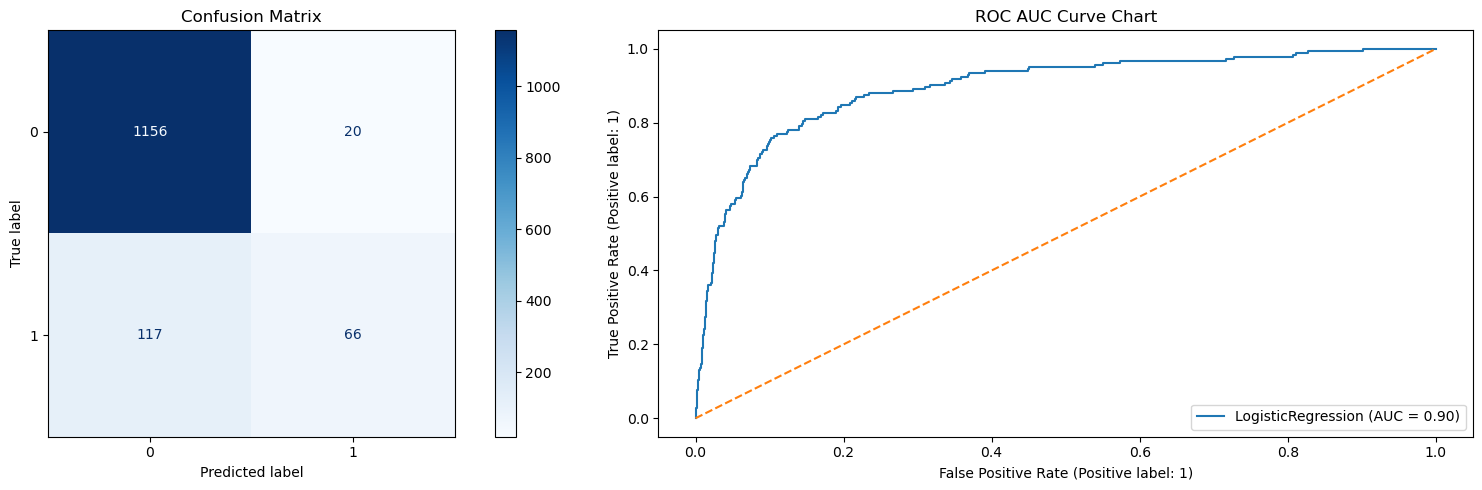

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(17,5))


cm_chart = ConfusionMatrixDisplay.from_estimator(logreg, X_test_sc, y_test, cmap='Blues', values_format='d', ax=axes[0]) #plot_confusion_matrix(logreg, X_test_sc, y_test, cmap='Blues', values_format='d', ax=axes[0]);
axes[0].title.set_text('Confusion Matrix')
roc_curve = RocCurveDisplay.from_estimator(logreg, X_test_sc, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], label='baseline', linestyle='--' )
axes[1].title.set_text('ROC AUC Curve Chart')

fig.tight_layout()

Based on the results, we have Accuracy = 0.874, which is normally a good result. However, the accuracy score for is actually close to the baseline class distribution of the test set (0: 0.865, 1: 0.135).

By taking a closer look, we see that Sensitivity is 0.361 and Precision is 0.767. From the confusion matrix above, we confirmed that this model is not good at predicting a majority of the cases in the positive class (True Positive < False Positive). In real world applications, this model will not be able to correctly predict patients with diabetes, leading to patients not getting the help they need.

The reason for this poor result is due to the high imbalanced distribution of positive vs. negative classes mentioned and currently, the number of data in the positive class is not sufficient in providing a good predictive model.

There can be several methods that can address this, amongst which are:
1) Random over/undersampling of the minority/majority classes,

2) Some models' class weight balance parameters (e.g. scale_pos_weight for xgboost),

3) Choosing for certain scoring metrics rather than Accuracy, like f1 score.

Thus, before moving on to the exploration of models, Synthetic Minority Oversampling Technique (SMOTE) will be employed. This method aims to balance class distribution by randomly increasing minority class by replicating the minority observations (or option 1 in the list above).

### Model Building with Hypertuning

A pipeline model and GridSearchCV will be used to build the models. Scoring for the cross-validation will employ ROC-AUC as its metric.


####  Logistic Regression (with SMOTE)

In [36]:
# Creating a pipeline model for SMOTE and Logistic Regression.
pipe_smote_logreg = Pipeline([
                ('sampling', SMOTE(random_state=42)),
                 ('logreg', LogisticRegression(random_state=42))
                ])

pipe_smote_logreg_params = {
    'logreg__solver': ['lbfgs','liblinear'],
    'logreg__penalty': ['l2'],
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logreg__max_iter': [500, 1000, 2500, 5000],
    'sampling__sampling_strategy': ['auto','minority'],
    'sampling__k_neighbors': [10, 11, 12, 13, 14, 15],
}

gs_smote_logreg = GridSearchCV(pipe_smote_logreg, pipe_smote_logreg_params, verbose=1, n_jobs=-1, scoring = 'roc_auc')

gs_smote_logreg.fit(X_train_sc, y_train) 

Fitting 5 folds for each of 672 candidates, totalling 3360 fits


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('logreg',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'logreg__max_iter': [500, 1000, 2500, 5000],
                         'logreg__penalty': ['l2'],
                         'logreg__solver': ['lbfgs', 'liblinear'],
                         'sampling__k_neighbors': [10, 11, 12, 13, 14, 15],
                         'sampling__sampling_strategy': ['auto', 'minority']},
             scoring='roc_auc', verbose=1)

In [39]:
print("Best params: {}".format(gs_smote_logreg.best_params_))

Best params: {'logreg__C': 0.01, 'logreg__max_iter': 500, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'sampling__k_neighbors': 14, 'sampling__sampling_strategy': 'auto'}


In [52]:
X_test.join(y_test)

,age,leg,waist,sub,gh,albumin,bun,dx
0,39.416667,45.3,120.9,24.00,5.7,4.2,19.0,NaN
1,44.833333,40.5,106.9,39.80,4.9,3.7,11.0,NaN
2,76.000000,43.5,111.1,24.16,6.1,4.4,15.0,1.0
3,61.666667,40.0,80.8,15.50,5.9,4.5,15.0,NaN
4,80.000000,36.1,119.3,19.20,6.3,4.1,23.0,0.0
...,...,...,...,...,...,...,...,...
1354,61.666667,43.0,109.1,28.00,5.4,4.0,18.0,NaN
1355,18.250000,36.6,77.6,17.30,5.5,4.1,8.0,0.0
1356,40.416667,45.2,92.2,29.20,5.2,4.4,5.0,NaN
1357,80.000000,38.0,89.2,15.00,5.5,4.2,11.0,NaN


In [40]:
#metrics calculations
preds_smotelr = gs_smote_logreg.predict(X_test_sc)
tn, fp, fn, tp = confusion_matrix(y_test, preds_smotelr).ravel()
acc = (tp + tn) / (tn + fp + fn + tp)
misclass = 1 - acc
sens = tp / (tp + fn)
spec = tn / (tn + fp)
prec = tp / (tp + fp)
f_one_score = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, gs_smote_logreg.predict_proba(X_test_sc)[:,1])

#printing out the scores
print('\033[4mLogistic Regression with Smote\033[0m')
print('Sensitivity:', sens)
print('Accuracy:',acc)
print('Specificity:',spec)
print('Precision:',prec)
print('f1 score:',f_one_score)
print('AUC_CV: {}'.format(gs_smote_logreg.best_score_))
print('ROC AUC:',roc_auc)

Logistic Regression with Smote
Sensitivity: 0.819672131147541
Accuracy: 0.8278145695364238
Specificity: 0.8290816326530612
Precision: 0.42735042735042733
f1 score: 0.5617977528089887
AUC_CV: 0.8843694180684226
ROC AUC: 0.8953756365934351


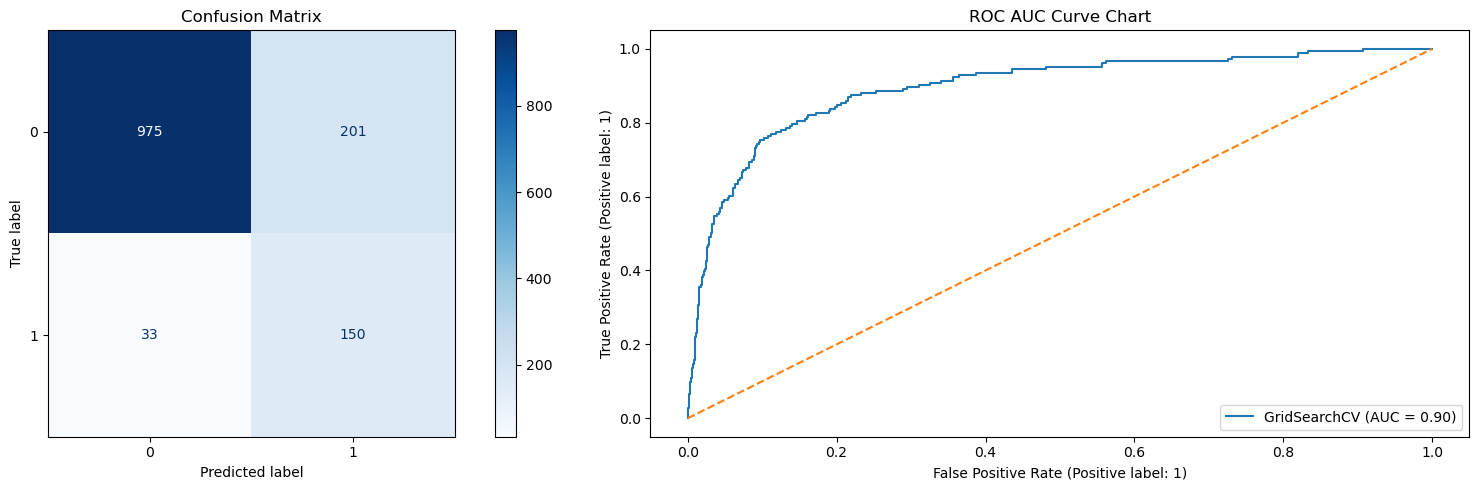

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(17,5))
    
cm_chart = ConfusionMatrixDisplay.from_estimator(gs_smote_logreg, X_test_sc, y_test, cmap='Blues', values_format='d', ax=axes[0]);
axes[0].title.set_text('Confusion Matrix')
roc_curve = RocCurveDisplay.from_estimator(gs_smote_logreg, X_test_sc, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], label='baseline', linestyle='--' )
axes[1].title.set_text('ROC AUC Curve Chart')
fig.tight_layout()

**Summary**

For this model, we are re-running Logistic Regression with SMOTE. We see improvement in this model in detecting the minority class although the Accuracy has dropped to 0.828. Despite that, this model has accurately predicted 150 observations with of diabetes present, a marked increase from the Base Model.




#### Random Forest (with SMOTE)

In [23]:
# Creating a pipeline model for SMOTE and Random Forest.
pipe_smote_rf = Pipeline([
                ('sampling', SMOTE(random_state=42)),
                  ('rf',RandomForestClassifier(random_state=42))
                ])

pipe_smote_rf_params = {
    'sampling__sampling_strategy': ['auto','minority'],
    'sampling__k_neighbors': [10, 11, 12, 13, 14],
    'rf__n_estimators': [150, 200, 250],
    'rf__max_depth':[None, 2, 3, 4],
    
}

gs_smote_rf = GridSearchCV(pipe_smote_rf, pipe_smote_rf_params, verbose=1, n_jobs=-1, scoring = 'roc_auc')

gs_smote_rf.fit(X_train_sc, y_train) 

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 2, 3, 4],
                         'rf__n_estimators': [150, 200, 250],
                         'sampling__k_neighbors': [10, 11, 12, 13, 14],
                         'sampling__sampling_strategy': ['auto', 'minority']},
             scoring='roc_auc', verbose=1)

In [24]:
print("Best params: {}".format(gs_smote_rf.best_params_))


Best params: {'rf__max_depth': 4, 'rf__n_estimators': 150, 'sampling__k_neighbors': 10, 'sampling__sampling_strategy': 'auto'}


In [25]:
# for sorting out later, to confirm how we want to present modeling
preds = gs_smote_rf.predict(X_test_sc)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
acc = (tp + tn) / (tn + fp + fn + tp)
misclass = 1 - acc
sens = tp / (tp + fn)
spec = tn / (tn + fp)
prec = tp / (tp + fp)
f_one_score = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, gs_smote_rf.predict_proba(X_test_sc)[:,1])

#printing out the scores
print('\033[4mRandom Forest Classifier with Smote\033[0m')
print('Sensitivity:', sens)
print('Accuracy:',acc)
print('Specificity:',spec)
print('Precision:',prec)
print('f1 score:',f_one_score)
print('Train score: {}'.format(gs_smote_rf.best_score_))
print('ROC AUC:',roc_auc)


Random Forest Classifier with Smote
Sensitivity: 0.7759562841530054
Accuracy: 0.8491537895511405
Specificity: 0.8605442176870748
Precision: 0.46405228758169936
f1 score: 0.5807770961145193
Train score: 0.883164857225845
Test score: 0.8491537895511405
ROC AUC: 0.8878991487305303


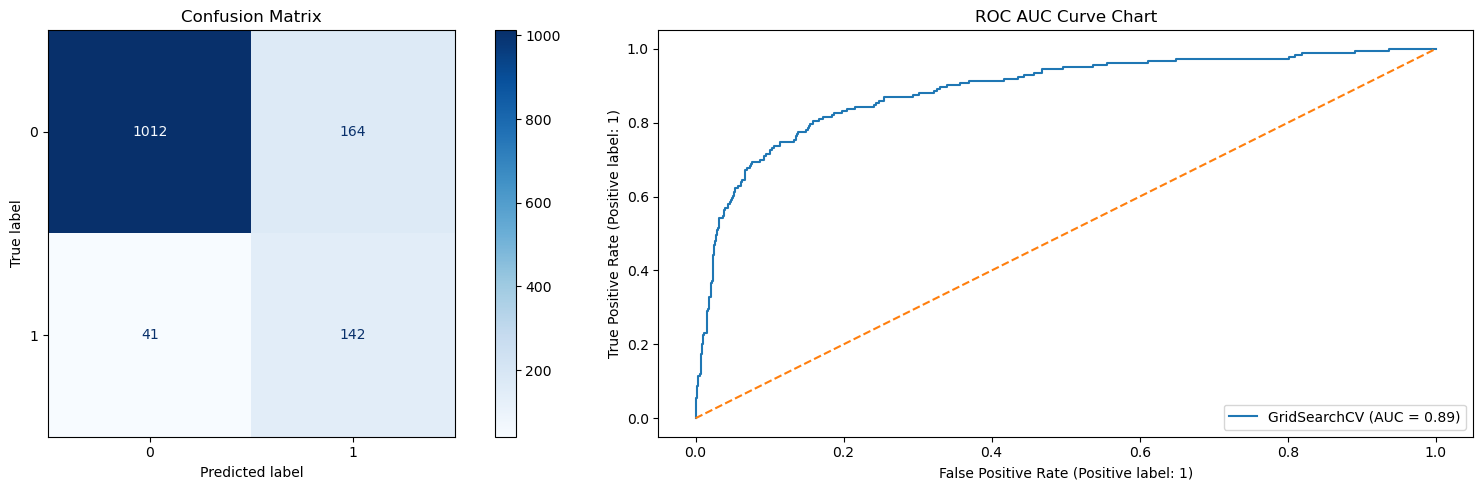

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(17,5))
    
cm_chart = ConfusionMatrixDisplay.from_estimator(gs_smote_rf, X_test_sc, y_test, cmap='Blues', values_format='d', ax=axes[0]);
axes[0].title.set_text('Confusion Matrix')
roc_curve = RocCurveDisplay.from_estimator(gs_smote_rf, X_test_sc, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], label='baseline', linestyle='--' )
axes[1].title.set_text('ROC AUC Curve Chart')
fig.tight_layout()


**Summary**

We are using Random Forest for this model. We have increased the Accuracy Score as compared to LogReg with SMOTE. However, both the ROC AUC and Sensitivity scores have decreased. This can be seen by the model only able to predict correctly 142 observations in the positive class, lesser than for LogReg.

#### Decision Tree (with SMOTE)

In [27]:
# Creating a pipeline model for SMOTE and Decision Tree.
pipe_smote_dt = Pipeline([
                ('sampling', SMOTE(random_state=42)),
                  ('dt',DecisionTreeClassifier(random_state=42))
                ])

pipe_smote_dt_params = {
    'sampling__sampling_strategy': ['auto','minority'],
    'sampling__k_neighbors': [10, 11, 12, 13, 14, 15],
    'dt__criterion': ['gini', 'entropy', 'log_loss'],
    'dt__max_depth': [None, 1, 2, 3, 4, 5],
    'dt__min_samples_split': [2, 3, 4, 5]    
}

gs_smote_dt = GridSearchCV(pipe_smote_dt, pipe_smote_dt_params, verbose=1, n_jobs=-1, scoring = 'roc_auc')

gs_smote_dt.fit(X_train_sc, y_train) 

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__criterion': ['gini', 'entropy', 'log_loss'],
                         'dt__max_depth': [None, 1, 2, 3, 4, 5],
                         'dt__min_samples_split': [2, 3, 4, 5],
                         'sampling__k_neighbors': [10, 11, 12, 13, 14, 15],
                         'sampling__sampling_strategy': ['auto', 'minority']},
             scoring='roc_auc', verbose=1)

In [28]:
print("Best params: {}".format(gs_smote_dt.best_params_))

Best params: {'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__min_samples_split': 2, 'sampling__k_neighbors': 11, 'sampling__sampling_strategy': 'auto'}


In [29]:
# for sorting out later, to confirm how we want to present modeling
preds = gs_smote_dt.predict(X_test_sc)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
acc = (tp + tn) / (tn + fp + fn + tp)
misclass = 1 - acc
sens = tp / (tp + fn)
spec = tn / (tn + fp)
prec = tp / (tp + fp)
f_one_score = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, gs_smote_dt.predict_proba(X_test_sc)[:,1])

#printing out the scores
print('\033[4mDecision Tree Classifier with Smote\033[0m')
print('Sensitivity:', sens)
print('Accuracy:',acc)
print('Specificity:',spec)
print('Precision:',prec)
print('f1 score:',f_one_score)
print('Train score: {}'.format(gs_smote_dt.best_score_))
print('ROC AUC:',roc_auc)


Decision Tree Classifier with Smote
Sensitivity: 0.6994535519125683
Accuracy: 0.8741721854304636
Specificity: 0.9013605442176871
Precision: 0.5245901639344263
f1 score: 0.5995316159250585
Train score: 0.8710368353883705
Test score: 0.8741721854304636
ROC AUC: 0.8704927326121705


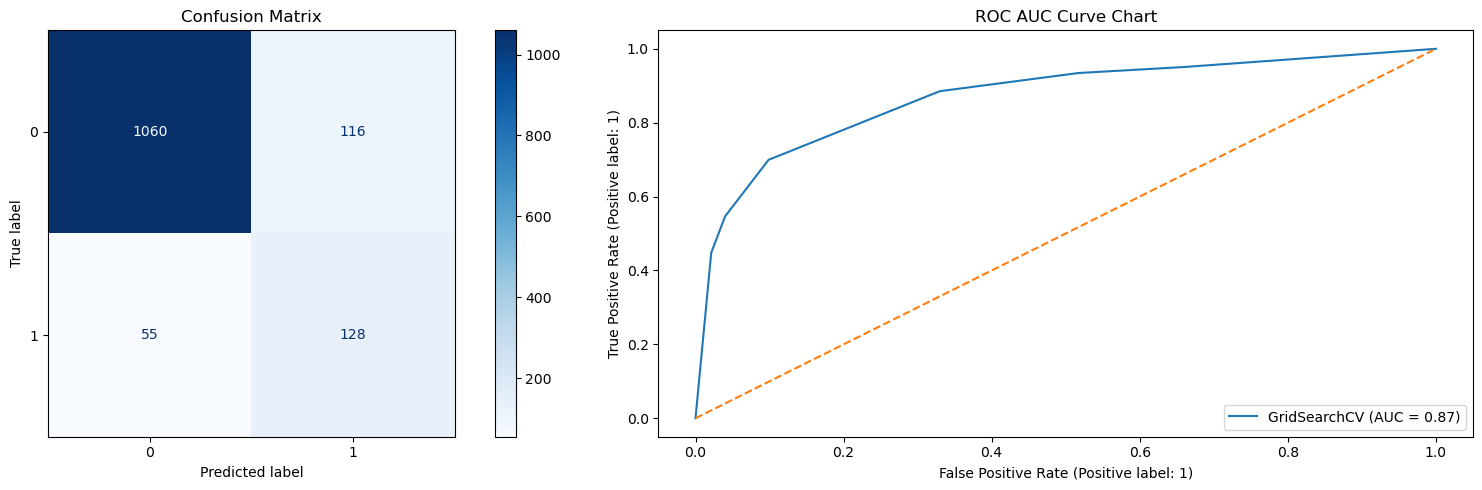

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(17,5))
    
cm_chart = ConfusionMatrixDisplay.from_estimator(gs_smote_dt, X_test_sc, y_test, cmap='Blues', values_format='d', ax=axes[0]);
axes[0].title.set_text('Confusion Matrix')
roc_curve = RocCurveDisplay.from_estimator(gs_smote_dt, X_test_sc, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], label='baseline', linestyle='--' )
axes[1].title.set_text('ROC AUC Curve Chart')
fig.tight_layout()


**Summary**

For Decision Tree, even with hypertuning, has the best Accuracy so far at the expense of the ROC AUC score. Sensitivity is also the worst and this can be seen by the model predicting the least number of observations in the True Positive class.

#### Summary of Results


|Model|---|HyperParameters|<b>Sensitivity</b>|Accuracy|Specificity|Precision|F1 Score|AUC_CV|<b>ROC AUC</b>|Remarks|
|---|---|---|---|---|---|---|---|---|---|---|
|Base Model|Logistic Regression|---|0.361|0.899|0.983|0.767|0.491|0.884|0.896|---|
|Model 1|Logistic Regression,SMOTE|'logreg__C': 0.01, 'logreg__max_iter': 500, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'sampling__k_neighbors': 14, 'sampling__sampling_strategy': 'auto'|<b>0.819</b>|0.828|0.829|0.427|0.562|0.884|<b>0.895</b>|<b>Best Model</b>|
|Model 2|Random Forest,SMOTE|'rf__max_depth': 4, 'rf__n_estimators': 150, 'sampling__k_neighbors': 10, 'sampling__sampling_strategy': 'auto'|0.776|0.849|0.860|0.464|0.581|0.883|0.889|---|
|Model 3|Decision Tree,SMOTE|'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__min_samples_split': 2, 'sampling__k_neighbors': 11, 'sampling__sampling_strategy': 'auto'|0.699|0.874|0.901|0.525|0.600|0.871|0.870|---|

As mentioned, inability to correctly identify true positives will lead to patients who are diabetic not getting the help they need when we use this model in a real world setting. I believe that letting patients being undiagnosed is costlier to Public Health as compared to the increase in number of doctor's appointments, especially if we are to look at the situation in the lens of preventive care.

Hence, picking out the best model out of the three will depend more on the Sensitivity and ROC AUC scores (to aim to reduce Type II errors (False Negatives)). Thus, Model 1 (Logistic Regression, SMOTE) is the best model out of the three, with the highest score for both (Sensitivity = 0.819, ROC AUC = 0.895).

Should the model were to be published/pushed to production, the model will have to be retrained on the whole dataset (prior to train-test split). 

## Feature Importance Analysis

In [38]:
# create table to show the predictors with the highest importance (i.e. strongest predictors of the presence of diabetes)
feature_names = X.columns
coefficients = pd.DataFrame(np.squeeze(gs_smote_logreg.best_estimator_.named_steps['logreg'].coef_),columns=['Coeff'])
features = pd.DataFrame(np.squeeze(feature_names), columns=['Features']) 

feature_impt = pd.concat([features, coefficients], axis='columns').sort_values('Coeff', ascending=False)

feature_impt

,Features,Coeff
4,gh,1.225975
0,age,0.495597
2,waist,0.371633
3,sub,0.223999
6,bun,0.114112
5,albumin,0.017824
1,leg,-0.196669


From the table of coefficients, we see that [gh] has a highest coefficient, followed by [age] and then [waist] with [sub] not far behind. The model training resulted in these few features being the most important (note: importance is measure by the absolute value of the coefficient) and is in line with our findings from EDA from the previous section. The reasoning as to why a higher coefficient leads to a higher importance is because a 1 unit change in the feature will lead to a more than 1 unit change in the log-odds of the target variable. In laymen terms, a feature is of higher importance when it has a higher impact to the target, and consequently, on the predicted probability of the outcome.

**Reasons behind Feature Importance**
- gh (Glycohemoglobin): The measure of your average level of blood sugar over the past 2-3 months. Thus, it is natural that this measure is the strongest predictor for diabetes.
(https://www.webmd.com/diabetes/glycated-hemoglobin-test-hba1c)
- age: The prevalence of both type 2 diabetes and prediabetes increases with advancing age leading to deficiency of insulin secretion and growing insulin resistance caused by a change in body composition (due to sarcopaenia).
(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5509969/#:~:text=The%20prevalence%20of%20both%20type,in%20body%20composition%20and%20sarcopaenia.)
- waist (Waist Circumference) & sub (Subscapular Skinfold): Directly correlated to body fat percentage. Lean body mass plays a role in reducing blood sugar, while fat tissue reduces insulin secretion, which can in turn lead to hyperglycemia. Thus, a person with greater lean body mass could have a lower risk of developing type 2 diabetes than a person with less lean body mass. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6915175/#:~:text=lean%20body%20mass%20plays%20a,with%20less%20lean%20body%20mass.)


Thus, one can propose to reduce the amount of measurements done to reduce the patient cost and consultation length (only if the purpose is to do a preliminary test on diabetic risk).


## Error Analysis


Error analysis will focus on the 33 False Negatives that wasnt capture by our LogReg with SMOTE model. We will first merge the X_test, y_test, and the predicted y together into one DataFrame for ease of comparison.

In [107]:
err_X_test = X_test.join(df_preds_smotelr)
err_X_test = ddd.join(pd.DataFrame(y_test.tolist(), columns = ['dx']))
err_X_test


,age,leg,waist,sub,gh,albumin,bun,dx_pred,dx
0,39.416667,45.3,120.9,24.00,5.7,4.2,19.0,0,0
1,44.833333,40.5,106.9,39.80,4.9,3.7,11.0,0,0
2,76.000000,43.5,111.1,24.16,6.1,4.4,15.0,1,1
3,61.666667,40.0,80.8,15.50,5.9,4.5,15.0,0,0
4,80.000000,36.1,119.3,19.20,6.3,4.1,23.0,1,0
...,...,...,...,...,...,...,...,...,...
1354,61.666667,43.0,109.1,28.00,5.4,4.0,18.0,0,0
1355,18.250000,36.6,77.6,17.30,5.5,4.1,8.0,0,0
1356,40.416667,45.2,92.2,29.20,5.2,4.4,5.0,0,0
1357,80.000000,38.0,89.2,15.00,5.5,4.2,11.0,0,0


In [113]:
print(err_X_test[(err_X_test['dx_pred'] == 0) & (err_X_test['dx'] == 1)].shape)
err_X_test[(err_X_test['dx_pred'] == 0) & (err_X_test['dx'] == 1)].agg('mean') #filtering for False Negatives

(33, 9)


age        47.696970
leg        39.340606
waist      97.921212
sub        20.832121
gh          5.515152
albumin     4.296364
bun        12.600000
dx_pred     0.000000
dx          1.000000
dtype: float64

In [112]:
data_model[data_model['dx'] == 1].agg('mean')

age         59.981583
dx           1.000000
leg         36.784669
waist      108.177120
sub         24.342985
gh           6.957549
albumin      4.130960
bun         15.763842
dtype: float64

If we look at the Top 4 important feature for these 33 False Negatives, the means are {[gh] = 5.52, [age] = 47.7, [waist] = 97.9, [sub] = 20.8}, which is well below the respective means of the positive class for the whole population {6.96, 60.0, 108.2, 24.34} . This could mean that are other factors that aren't in the dataset that led to the initial classification, or that the patient is responding well to the treatment in keeping their diabetes at bay. We can better understand the reason behind the error by discussing with the clinicians.